In [1]:
import os
from ast import literal_eval

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

import fastestimator as fe
from fastestimator.architecture.retinanet import RetinaNet, get_fpn_anchor_box, get_target
from fastestimator.op import NumpyOp
from fastestimator.op.numpyop import ImageReader, ResizeImageAndBbox, TypeConverter
from fastestimator.op.tensorop import Loss, ModelOp, Pad, Rescale

In [2]:
NMS_MAX_OUTPUT = 100
INPUT_SHAPE=(512, 512, 3)
BATCH_SIZE = 8

## Utilities

In [3]:
class String2List(NumpyOp):
    # this thing converts '[1, 2, 3]' into np.array([1, 2, 3])
    def forward(self, data, state):
        data = map(literal_eval, data)
        return data

In [4]:
class GenerateTarget(NumpyOp):
    def __init__(self, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.anchorbox, _ = get_fpn_anchor_box(input_shape=INPUT_SHAPE)

    def forward(self, data, state):
        obj_label, x1, y1, width, height = data
        cls_gt, x1_gt, y1_gt, w_gt, h_gt = get_target(self.anchorbox, obj_label, x1, y1, width, height)
        return cls_gt, x1_gt, y1_gt, w_gt, h_gt

In [5]:
all_anchors, num_anchors_per_level = get_fpn_anchor_box((512, 512, 3))

In [6]:
assert all_anchors.shape == (49104, 4)

In [7]:
assert all_anchors.shape[0] == num_anchors_per_level.sum()

## Original data

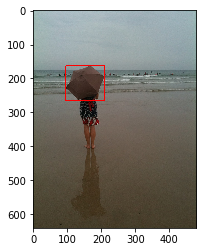

In [8]:
im = cv2.imread('/data/hsiming/dataset/MSCOCO2017/train2017/000000532867.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()

x1 = 96
y1 = 163
w = 113
h = 102

cv2.rectangle(im, (x1, y1), (x1+w, y1+h), (255, 0, 0), 2)
    
ax.imshow(im)

## Pipeline

In [9]:
train_csv = '/data/hsiming/dataset/MSCOCO2017/train_object.csv'
val_csv = '/data/hsiming/dataset/MSCOCO2017/val_object.csv'
path = '/data/hsiming/dataset/MSCOCO2017/'

In [10]:
writer = fe.RecordWriter(
    save_dir=os.path.join(path, "retinanet_coco"),
    train_data=train_csv,
    validation_data=val_csv,
    ops=[
        ImageReader(inputs="image", parent_path=path, outputs="image"),
        String2List(inputs=["x1", "y1", "width", "height", "obj_label"],
                    outputs=["x1", "y1", "width", "height", "obj_label"]),
        ResizeImageAndBbox(target_size=(512, 512),
                           keep_ratio=True,
                           inputs=["image", "x1", "y1", "width", "height"],
                           outputs=["image", "x1", "y1", "width", "height"]),
        GenerateTarget(inputs=("obj_label", "x1", "y1", "width", "height"),
                       outputs=("cls_gt", "x1_gt", "y1_gt", "w_gt", "h_gt")),
        TypeConverter(target_type='int32', inputs=["id", "cls_gt"], outputs=["id", "cls_gt"]),
        TypeConverter(target_type='float32',
                      inputs=["x1_gt", "y1_gt", "w_gt", "h_gt"],
                      outputs=["x1_gt", "y1_gt", "w_gt", "h_gt"])
    ],
    compression="GZIP",
    write_feature=["image", "id", "cls_gt", "x1_gt", "y1_gt", "w_gt", "h_gt"])

In [11]:
# prepare pipeline
pipeline = fe.Pipeline(
    batch_size=BATCH_SIZE,
    data=writer,
    ops=[
        Rescale(inputs="image", outputs="image"),
        Pad(padded_shape=[190], inputs=["x1_gt", "y1_gt", "w_gt", "h_gt"], outputs=["x1_gt", "y1_gt", "w_gt", "h_gt"])
    ])

In [12]:
batch_data = pipeline.show_results(mode='train', num_steps=1)

FastEstimator: Reading non-empty directory: /data/hsiming/dataset/MSCOCO2017/retinanet_coco
FastEstimator: Found 117266 examples for train in /data/hsiming/dataset/MSCOCO2017/retinanet_coco/train_summary0.json
FastEstimator: Found 4952 examples for eval in /data/hsiming/dataset/MSCOCO2017/retinanet_coco/eval_summary0.json


In [13]:
batch_data[0].keys()

dict_keys(['w_gt', 'cls_gt', 'id', 'image', 'x1_gt', 'y1_gt', 'h_gt'])

In [14]:
batch_data[0]['image'].shape

TensorShape([8, 512, 512, 3])

id = 513056


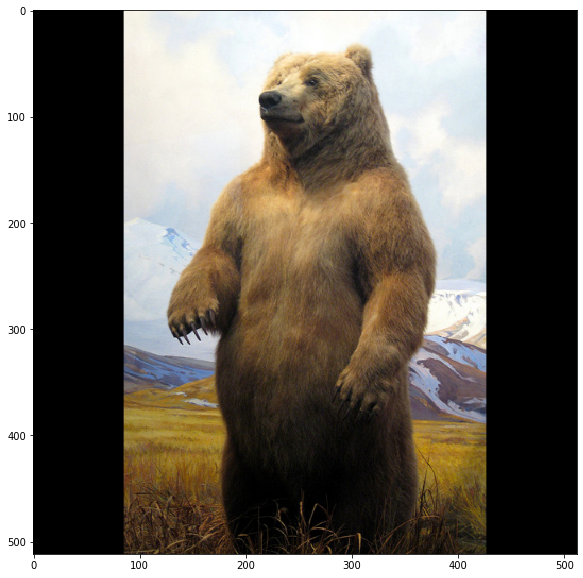

In [15]:
index = 3
img = batch_data[0]['image'].numpy()[index]
img = ((img + 1) / 2 * 255).astype(np.uint8)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

print("id = {}".format(batch_data[0]['id'].numpy()[index]))

In [16]:
gt_cls = batch_data[0]['cls_gt'].numpy()[index]

In [17]:
class_args = np.argwhere(gt_cls > 0)

In [18]:
class_args

array([[49013]])

In [19]:
gt_cls[class_args]

array([[23]], dtype=int32)

In [20]:
selected_anchors = all_anchors[class_args]

In [21]:
selected_anchors.shape

(1, 1, 4)

In [22]:
selected_anchors

array([[[120.16243,  48.32486, 143.67514, 287.35028]]], dtype=float32)

In [23]:
x1 = batch_data[0]['x1_gt'].numpy()[index]
y1 = batch_data[0]['y1_gt'].numpy()[index]
w = batch_data[0]['w_gt'].numpy()[index]
h = batch_data[0]['h_gt'].numpy()[index]

In [24]:
(x1[12] * selected_anchors[-1, 0, 2]) + selected_anchors[-1, 0, 0]

120.16243

In [25]:
(y1[12] * selected_anchors[-1, 0, 3]) + selected_anchors[-1, 0, 1]

48.32486

In [26]:
np.exp(w[12]) * selected_anchors[-1, 0, 2]

143.67514

In [27]:
np.exp(h[12]) * selected_anchors[-1, 0, 3]

287.35028

## Model inference 

In [28]:
trained_model = load_model('/data/hsiming/dev/retinanet_best_total_loss.h5', compile=False)

In [29]:
cls, delta = trained_model(batch_data[0]['image'])

In [30]:
delta.shape

TensorShape([8, 49104, 4])

In [31]:
cls.shape

TensorShape([8, 49104, 90])

In [32]:
# cls = np.squeeze(cls.numpy())
# delta = np.squeeze(delta.numpy())

In [33]:
cls_pred = tf.argmax(cls, axis=2)
score = tf.reduce_max(cls, axis=2)

In [34]:
cls_pred.shape

TensorShape([8, 49104])

In [35]:
score.shape

TensorShape([8, 49104])

### TensorFlow

#### Loop through level

In [36]:
num_anchors_per_level

array([36864,  9216,  2304,   576,   144], dtype=int32)

In [37]:
def index_to_bool(indices, length):
    updates = tf.ones_like(indices, dtype=tf.bool)
    shape = tf.constant([length], dtype=tf.int64)
    is_selected = tf.scatter_nd(tf.cast(tf.expand_dims(indices, axis=-1), dtype=tf.int64), updates, shape)
    return is_selected

In [39]:
# tensorflow

batch_boxes = []
batch_score = []
batch_cls = []
#batch_anchor_indices = [] # for debug only

select_top_k = 1000

# for each image
for i in range(score.shape[0]):
    cls_pred_per_image = cls_pred[i]
    score_per_image = score[i]
    delta_per_image = delta[i]
    end_index = 0
    
    selected_delta_per_image = tf.transpose(tf.constant([[], [], [], []]))
    selected_cls_per_image = tf.constant([], dtype=tf.int64)
    selected_score_per_image = tf.constant([])
    selected_anchor_indices_per_image = tf.constant([], dtype=tf.int64)
    
    # for each pyramid level in one image
    for j in range(len(num_anchors_per_level)):
        start_index = end_index
        end_index += num_anchors_per_level[j]

        
        level_score = score_per_image[start_index:end_index]  
        level_delta = delta_per_image[start_index:end_index, :]
        level_cls_pred = cls_pred_per_image[start_index:end_index]
        anchor_indices = tf.range(start_index, end_index, dtype=tf.int64)
        
        # select top 1k
        if num_anchors_per_level[j] >= select_top_k:
            top_k = tf.math.top_k(level_score, select_top_k)
            top_k_scores = top_k.values
            top_k_indices = tf.add(top_k.indices, [start_index])
        else:
            top_k_scores = level_score
            top_k_indices = anchor_indices
        
        # filter out low score
        is_high_score = tf.greater(top_k_scores, 0.05)  
        selected_indices = tf.boolean_mask(top_k_indices, is_high_score)
        
        is_selected = index_to_bool(tf.subtract(selected_indices, [start_index]), level_delta.shape[0])
        
        # combine all levels in one image
        selected_delta_per_image = tf.concat([selected_delta_per_image, tf.boolean_mask(level_delta, is_selected)], axis=0)
        selected_score_per_image = tf.concat([selected_score_per_image, tf.boolean_mask(level_score, is_selected)], axis=0)
        selected_cls_per_image = tf.concat([selected_cls_per_image, tf.boolean_mask(level_cls_pred, is_selected)], axis=0)
        selected_anchor_indices_per_image = tf.concat([selected_anchor_indices_per_image, tf.boolean_mask(anchor_indices, is_selected)], axis=0)
    
    # apply delta
    anchor_mask = index_to_bool(selected_anchor_indices_per_image, all_anchors.shape[0])
    x1 = (selected_delta_per_image[:, 0] * tf.boolean_mask(all_anchors, anchor_mask)[:, 2]) + tf.boolean_mask(all_anchors, anchor_mask)[:, 0]    
    y1 = (selected_delta_per_image[:, 1] * tf.boolean_mask(all_anchors, anchor_mask)[:, 3]) + tf.boolean_mask(all_anchors, anchor_mask)[:, 1]    
    w = tf.math.exp(selected_delta_per_image[:, 2]) * tf.boolean_mask(all_anchors, anchor_mask)[:, 2]
    h = tf.math.exp(selected_delta_per_image[:, 3]) * tf.boolean_mask(all_anchors, anchor_mask)[:, 3]
    x2 = x1 + w
    y2 = y1 + h
    
    # nms 
    boxes_per_image = tf.stack([y1, x1, y2, x2], axis=1)
    nms = tf.image.non_max_suppression_padded(boxes_per_image, selected_score_per_image, NMS_MAX_OUTPUT, pad_to_max_output_size=True)
    nms_indices = nms.selected_indices[:nms.valid_outputs]
    nms_boxes = tf.gather(boxes_per_image, nms_indices)
    x1 = tf.clip_by_value(nms_boxes[:, 1], clip_value_min=0, clip_value_max=INPUT_SHAPE[1])
    y1 = tf.clip_by_value(nms_boxes[:, 0], clip_value_min=0, clip_value_max=INPUT_SHAPE[0])
    w = tf.clip_by_value(nms_boxes[:, 3], clip_value_min=0, clip_value_max=INPUT_SHAPE[1]) - x1
    h = tf.clip_by_value(nms_boxes[:, 2], clip_value_min=0, clip_value_max=INPUT_SHAPE[0]) - y1
    final_boxes = tf.stack([x1, y1, w, h], axis=1)
    
    final_score = tf.gather(selected_score_per_image, nms_indices)
    final_cls = tf.gather(selected_cls_per_image, nms_indices)
    
    # create batch  
    print("i = {}, valid anchors = {}".format(i, nms.valid_outputs))
    # pad to NMS_MAX_OUTPUT
    padding = NMS_MAX_OUTPUT - nms.valid_outputs
    padded_boxes = tf.pad(final_boxes, [[0, padding], [0, 0]], constant_values=-1)
    padded_score = tf.pad(final_score, [[0, padding]], constant_values=-1)
    padded_cls = tf.pad(final_cls, [[0, padding]], constant_values=-1)
    
    batch_boxes.append(padded_boxes) 
    batch_score.append(padded_score)
    batch_cls.append(padded_cls)
    
    #batch_anchor_indices.append(tf.gather(selected_anchor_indices_per_image, nms_indices.selected_indices))

i = 0, valid anchors = 16
i = 1, valid anchors = 49
i = 2, valid anchors = 100
i = 3, valid anchors = 5
i = 4, valid anchors = 42
i = 5, valid anchors = 58
i = 6, valid anchors = 98
i = 7, valid anchors = 100


In [40]:
tf.stack(batch_boxes).shape

TensorShape([8, 100, 4])

id = 470766


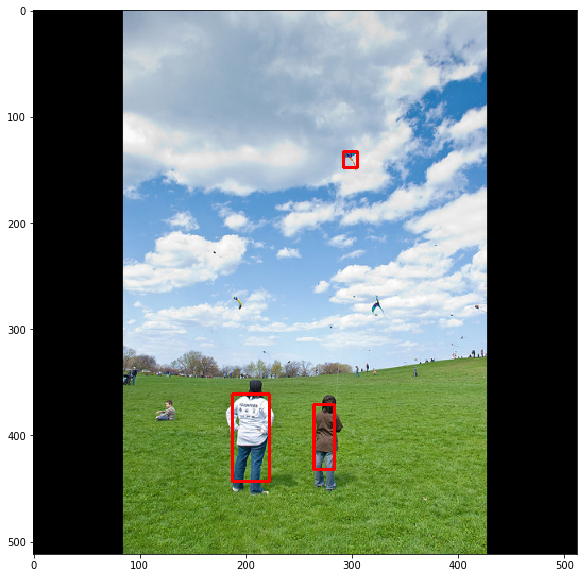

In [41]:
index = 7
img = batch_data[0]['image'].numpy()[index]
img = ((img + 1) / 2 * 255).astype(np.uint8)

x1 = batch_boxes[index][:, 0]
y1 = batch_boxes[index][:, 1]
x2 = x1 + batch_boxes[index][:, 2]
y2 = y1+ batch_boxes[index][:, 3]

for i in range(np.min([3, batch_boxes[index].shape[0]])):
    cv2.rectangle(img, (x1[i], y1[i]), (x2[i], y2[i]), (255, 0, 0), 2)
    #print([x1[i].numpy(), y1[i].numpy(), x2[i].numpy(), y2[i].numpy()])
    
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

print("id = {}".format(batch_data[0]['id'].numpy()[index]))

### Numpy

In [ ]:
# numpy
end_index = 0

selected_delta = []
selected_score = []
selected_cls = []
selected_anchor_indices = []

select_top = 1000

# loop through each pyramid level
for i in range(len(num_anchors_per_level)):
    start_index = end_index
    end_index += num_anchors_per_level[i]
    
    anchor_indices = np.arange(start_index, end_index)
    level_score = score.numpy()[index, anchor_indices]
    
    # select top 1k
    if num_anchors_per_level[i] >= select_top:
        topk_indices = np.argsort(-level_score)[:select_top]  # negative sign for descending order
    else:
        topk_indices = np.array(range(len(level_score)))
        
    # filter out low score
    is_high_score = level_score[topk_indices] > 0.05
    selected_indices = topk_indices[is_high_score]
    
    selected_score.append(level_score[selected_indices])
    
    selected_delta.append(delta[index].numpy()[anchor_indices, :][selected_indices, :])
    selected_cls.append(cls_pred[index].numpy()[anchor_indices][selected_indices])
    selected_anchor_indices.append(anchor_indices[selected_indices])

In [ ]:
selected_score = np.concatenate(selected_score, axis=0)
selected_delta = np.concatenate(selected_delta, axis=0)
selected_cls = np.concatenate(selected_cls, axis=0)
selected_anchor_indices = np.concatenate(selected_anchor_indices, axis=0)

In [ ]:
descend = np.argsort(-selected_score)

In [ ]:
selected_score = selected_score[descend]
selected_delta = selected_delta[descend, :]
selected_cls = selected_cls[descend]
selected_anchor_indices = selected_anchor_indices[descend]

In [ ]:
selected_score.shape

In [ ]:
selected_delta.shape

In [ ]:
selected_cls.shape

In [ ]:
selected_anchor_indices.shape

In [ ]:
selected_score

#### Apply deltas

In [ ]:
x1 = (selected_delta[:, 0] * all_anchors[selected_anchor_indices][:, 2]) + all_anchors[selected_anchor_indices][:, 0]

In [ ]:
y1 = (selected_delta[:, 1] * all_anchors[selected_anchor_indices][:, 3]) + all_anchors[selected_anchor_indices][:, 1]

In [ ]:
w = np.exp(selected_delta[:, 2]) * all_anchors[selected_anchor_indices][:, 2]

In [ ]:
h = np.exp(selected_delta[:, 3]) * all_anchors[selected_anchor_indices][:, 3]

In [ ]:
x2 = x1 + w

In [ ]:
y2 = y1 + h

In [ ]:
# img = batch_data[0]['image'].numpy()[index]
# img = ((img + 1) / 2 * 255).astype(np.uint8)


# for i in range(4):
#     cv2.rectangle(img, (x1[i], y1[i]), (x2[i], y2[i]), (255, 0, 0), 2)

# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(img)

# print("id = {}".format(batch_data[0]['id'].numpy()[index]))

#### NMS

In [ ]:
boxes = np.vstack([y1, x1, y2, x2]).T

In [ ]:
final_boxes = tf.image.non_max_suppression(boxes, selected_score, NMS_MAX_OUTPUT)

In [ ]:
assert np.array_equal(selected_anchor_indices[final_boxes.numpy()], batch_anchor_indices[index].numpy())

In [ ]:
img = batch_data[0]['image'].numpy()[index]
img = ((img + 1) / 2 * 255).astype(np.uint8)

for i in final_boxes.numpy()[:3]:
    print([x1[i], y1[i], x2[i], y2[i]])
    cv2.rectangle(img, (x1[i], y1[i]), (x2[i], y2[i]), (255, 0, 0), 2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

print("id = {}".format(batch_data[0]['id'].numpy()[index]))

In [ ]:
img = batch_data[0]['image'].numpy()[index]
img = ((img + 1) / 2 * 255).astype(np.uint8)


for i in final_boxes.numpy():
    cv2.rectangle(img, (x1[i], y1[i]), (x2[i], y2[i]), (255, 0, 0), 2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

print("id = {}".format(batch_data[0]['id'].numpy()[index]))